<a href="https://colab.research.google.com/github/aghaeifar/SpinWalk/blob/dev/demo/spinwalk_dwi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



If running this demo in Google Colab, **Switch to GPU**:



*   Go to Edit → Notebook Settings
*   Choose GPU from Hardware Accelerator






# Installing SpinWalk

In [14]:
%%bash
# install dependencies
apt-get install -y libboost-all-dev libhdf5-dev libtbb-dev

# clone SpinWalk
rm -rf SpinWalk
git clone --depth 1 https://github.com/aghaeifar/SpinWalk.git &> /dev/null

# build it
cd SpinWalk
cmake -B ./build
cmake --build ./build --config Release
cmake --install ./build

Reading package lists...
Building dependency tree...
Reading state information...
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
libhdf5-dev is already the newest version (1.10.7+repack-4ubuntu2).
libtbb-dev is already the newest version (2021.5.0-7ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
-- CMake version: 3.31.2
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found HDF5: /usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5_cpp.so;/usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5.so;/usr/lib/x8

In [1]:
%%bash
# test it runs and show help menu
echo "Running SpinWalk..."
spinwalk

# show version
echo -e "Print SpinWalk version..."
spinwalk --version

# print gpu info if available - note this command won't work if spinwalk is compiled without CUDA support
echo -e "\nPrint GPU info..."
spinwalk --gpu_info

Running SpinWalk...
Usage: spinwalk [OPTIONS] [SUBCOMMAND]

Options:
  -h,--help                             Print this help message and exit
  -v,--version                          Display program version information and exit
  -g,--gpu_info                         Print GPU information

Subcommands:
  sim                                   Run Monte-Carlo simulation
  phantom                               Generate numerical phantom
  config                                Generate configuration file
  dwi                                   Generate diffusion gradient table

Print SpinWalk version...
1.18.3

Print GPU info...
The latest version of CUDA supported by the driver: 12.5, current CUDA version: 12.6
Number of devices: 1
NVIDIA RTX A4000
-Compute Capability: 8.6
-Free GPU Memory: 14841 MB (out of 16009 MB)


# Generating Phantom

Here, **SpinWalk** generates a phantom containing spheres with a radius of 20 µm or less, mimicking cells. These spheres will occupy 50% of the total volume, and the phantom will have a field of view (FoV) of 600 µm. The phantom will be stored in the `phantoms` folder.

In [2]:
%%bash
echo "Print help menu for phantom generation..."
spinwalk phantom -h

Print help menu for phantom generation...
Generate numerical phantom
Usage: spinwalk phantom [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -c,--cylinder                         Fill phantom with cylinders
  -s,--sphere                           Fill phantom with spheres
  -r,--radius FLOAT [50]                Radius of the cylinders/spheres in µm (negative value = random but smaller than radius)
  -n,--orientation FLOAT [90]           Orientation of the cylinders in degree with respect to B0
  -v,--volume_fraction FLOAT [4]        Fraction of shapes volume to FoV volume in % <0.0 100.0>
  -f,--fov FLOAT:POSITIVE               Voxel field of view in µm (isotropic)
  -z,--resolution UINT:POSITIVE         Base resolution
  -d,--dchi FLOAT [1.1e-07]             Susceptibility difference between fully deoxygenated blood and tissue (default: 0.11e-6 in cgs units)
  -y,--oxy_level FLOAT [0.75]           Blood oxygenetation level <0.0 1.0> (-1 =

In [3]:
%%bash
# Define the output directory
output_dir="./phantoms"
mkdir -p "$output_dir"

vol_frac=40
resolution=600
fov=600
radius=-20
oxy_level=-1

# Define the output file
output_file="${output_dir}/r${radius}_vf${vol_frac}_fov${fov}_res${resolution}.h5"
# Call the command with the variable parameter and redirect the output
spinwalk phantom -s -r "$radius" -v "$vol_frac" -f "$fov" -z "$resolution" -y "$oxy_level" -e 0 -o "$output_file"

# check phantoms are there
echo -e "\nList of existing phantoms in phantom folder..."
ls -l --block-size=M ./phantoms


 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.18.3
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Generating sphere phantom...
Generating (1/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100/100 
Generating (2/2) 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183851/183851 
Done.

List of existing phantoms in phantom folder...
total 206M
-rw-r--r-- 1 aaghaeifar kyb 206M Jan  3 20:36 r-20_vf40_fov600_res600.h5


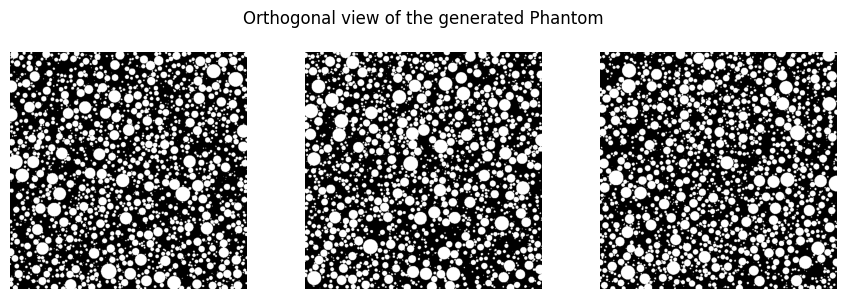

In [4]:
# plot the generated phantoms
import h5py
import matplotlib.pyplot as plt

def plot_phantom(file_path, title=None):
    with h5py.File(file_path, "r") as f:
        mask = f["mask"][()]
        sz = tuple(dim // 2 for dim in mask.shape)
        # print orthogonal views
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(mask[:, :, sz[2]], cmap="gray")
        axes[0].axis("off")
        axes[1].imshow(mask[:, sz[1], :], cmap="gray")
        axes[1].axis("off")
        axes[2].imshow(mask[sz[0], :, :], cmap="gray")
        axes[2].axis("off")

        # title
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# show the phantom
output_file= "./phantoms/r-20_vf40_fov600_res600.h5"
plot_phantom(output_file, title="Orthogonal view of the generated Phantom")


# Creating Configuration File
We will create multiple GRE configuration files and later update them to incorporate diffusion-sensitizing gradients.

In [5]:
%%bash
# help menu for generating config file
spinwalk config -h

Generate configuration file
Usage: spinwalk config [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -s,--seq_name TEXT                    Sequence name: GRE, SE, and bSSFP
  -p,--phantoms TEXT ...                Path to phantom files as many as you want. e.g. -p phantom1.h5 phantom2.h5 ... phantomN.h5
  -e,--TE UINT:POSITIVE                 Echo time in µs
  -t,--timestep UINT:POSITIVE           timestep in µs
  -o,--output TEXT                      Path to save the configuration file


## GRE configuration file as a base

In [6]:
%%bash
spinwalk config -s GRE --TE 60000 -t 50 -p ./phantoms/r-20_vf40_fov600_res600.h5 -o ./dwi.ini
# rename sequence name to dwi
sed -i "s/SEQ_NAME = gre/SEQ_NAME = dwi/g" ./dwi.ini

# prolong relaxation time in default config. This file is generated with gre config and serves as parent config for all GREs.
sed -i 's/T1\[0\] = 2200/T1\[0\] = 9999999/g' ./default_config.ini
sed -i 's/T1\[1\] = 2200/T1\[1\] = 9999999/g' ./default_config.ini
sed -i 's/T2\[0\] = 41/T2\[0\] = 9999999/g' ./default_config.ini
sed -i 's/T2\[1\] = 41/T2\[1\] = 9999999/g' ./default_config.ini

# and make permeable membranes -> free diffusion
sed -i 's/P_XY\[0\] = 1.0 0.0/P_XY\[0\] = 1.0 1.0/g' ./default_config.ini
sed -i 's/P_XY\[1\] = 0.0 1.0/P_XY\[1\] = 1.0 1.0/g' ./default_config.ini

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.18.3
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Configuration file is generated in /DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/dwi.ini


## Adding diffusion sensitizing gradients (PGSE like)

In [7]:
%%bash
# help menu for generating DWI
spinwalk dwi -h

Generate diffusion gradient table
Usage: spinwalk dwi [OPTIONS]

Options:
  -h,--help                             Print this help message and exit
  -b,--bvalue FLOAT ...                 b-value(s) as many as you want. e.g. -b 100 500 1000 5000 (s/mm²)
  -v,--bvector FLOAT x 3                Gradient direction: X Y Z, e.g. 0.267 0.534 0.801
  -d,--delta UINT x 3                   start time, δ and Δ in ms, e.g. 10 3 5 
  -c,--config TEXT:FILE                 input config file to insert PGSE gradients and excitation and refocusing RF


In [8]:
%%bash
# add diffusion encoding directions
list_of_bvalues=""
for ((bvalue=100; bvalue<=5000; bvalue+=100))
do
  list_of_bvalues+="$bvalue "
done
list_of_bvalues+="0"
spinwalk dwi -b $list_of_bvalues -v 1 0 0 -d  15 10 20 -c ./dwi.ini

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.18.3
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
Generating PGSE gradient table...
Diffusion gradient table is generated successfully.


# Simulation

SpinWalk will read all the provided config files and simulate them sequentially.

In [9]:
%%bash
spinwalk sim -c ./dwi.ini

 ____            _          __        __          _   _        
/ ___|   _ __   (_)  _ __   \ \      / /   __ _  | | | | __    
\___ \  | '_ \  | | | '_ \   \ \ /\ / /   / _` | | | | |/ /    
 ___) | | |_) | | | | | | |   \ V  V /   | (_| | | | |   <     
|____/  | .__/  |_| |_| |_|    \_/\_/     \__,_| |_| |_|\_\    
        |_|                                                    


SpinWalk Version: 1.18.3
Log file location: "/DATA/aaghaeifar/Nextcloud/Projects/microvascular/SpinWalk/demo/spinwalk_0.log"
<dwi.ini>
Simulating 100.00% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51/51 
Simulation completed successfully. See the log file


In [10]:
%%bash
# cat spinwalk_0.log
ls ./outputs

dwi_r-20_vf40_fov600_res600.h5


In [11]:
import os
import numpy as np
import h5py

tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
results_dir = './outputs/'
b_values = np.arange(100, 5100, 100)

def read_results(filename):
    signal_magnitude = []
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])
        S = np.array(h5['scales'])
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, 0, :]
            M_f = np.mean(M_f[...,0:2], axis=0)
            signal_magnitude.append(np.linalg.norm(M_f))
    return signal_magnitude


############

filename = './dwi_r-20_vf40_fov600_res600'
signal_magnitude = read_results(filename)
signal_magnitude = np.array(signal_magnitude)

with h5py.File(os.path.join(results_dir, f'{filename}.h5'), 'r') as h5:
    scales = np.array(h5['scales'])
b_values = scales*scales * 100
b_values = b_values.flatten()
signal_magnitude = np.concatenate(([signal_magnitude[-1]], signal_magnitude[:-1]))
b_values = np.concatenate(([b_values[-1]], b_values[:-1]))

# print(signal_magnitude.shape)
# print(b_values, b_values.size)

Fitted signal magnitude at b=0: 0.9945378205529307
Fitted diffusion coefficient   : 9.791574634924713e-10
Simulated diffusion coefficient: 1e-09


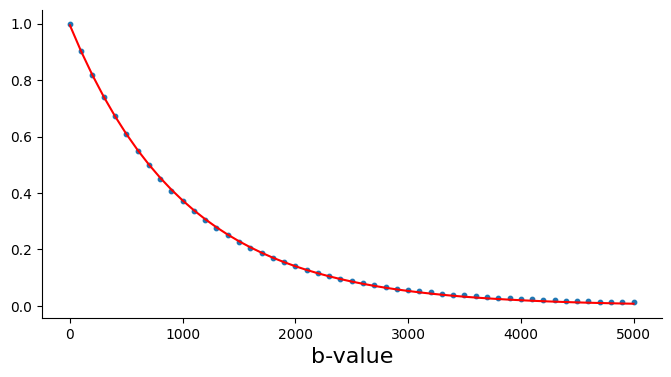

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the model function (exponential of the form exp1: a * exp(b * x))
def exp1(bvalue, a, D):
    return a * np.exp(-bvalue * D)

# Set initial parameters (StartPoint in MATLAB)
initial_params = [988912.916299669, -0.000461964926600495]
# Set additional options (equivalent to MATLAB fit options)
options = {'maxfev': 6000, 'ftol': 1e-9, 'xtol': 1e-9}

# Fit the model to the data
popt, pcov = curve_fit(exp1, b_values.astype(np.float32), signal_magnitude.astype(np.float32), p0=initial_params, **options)
# Extract fitting parameters and goodness of fit
a, D = popt
print(f"Fitted signal magnitude at b=0: {a}")
print(f"Fitted diffusion coefficient   :", D * 1e-6) # convert mm^2/s to m^2/ms
print(f"Simulated diffusion coefficient: {1e-9}")

plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output
plt.close('all')
BV   = [2, 5]
cmap = plt.get_cmap('Set2')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(b_values, signal_magnitude, s=10)
ax.plot(b_values, exp1(b_values, a,  D), 'r-')
ax.set_xlabel('b-value', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
